# Measure average swap volume for builders and relays


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import math
import pandas as pd
from dotenv import load_dotenv
import numpy as np

import statsmodels.api as sm

from tqdm import tqdm
from pathlib import Path

from concurrent.futures import ThreadPoolExecutor
from tqdm import trange, tqdm
import numpy as np
import pandas as pd

import seaborn as sns

import sys

current_path = sys.path[0]
sys.path.append(current_path[: current_path.find("defi-measurement")] + "liquidity-distribution-history")

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Adjust so all columns in dataframe are shown
pd.set_option("display.max_columns", None)

# Set pandas display options column width
pd.set_option("display.max_colwidth", 1000)

In [4]:
postgres_uri = os.environ["POSTGRESQL_URI"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## General idea: Use ETH as a proxy for swap volume

The assumption is that most the swaps happen between ETH and something else. First, though, verify this assumption.


### How to measure


In [5]:
weth_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"

From the below, we see that ~84% of transactions happen to or from ETH, so I think we can argue that it's a fair measure of swap volume.


In [6]:
total_swap_count = pd.read_sql_query(
    f"""
    SELECT COUNT(*)
    FROM swaps
    JOIN factory ON address = pool
    """,
    postgres_uri,
)["count"][0]

eth_swap_count = pd.read_sql_query(
    f"""
    SELECT COUNT(*)
    FROM swaps
    JOIN factory ON address = pool
    WHERE token0 = '{weth_address}'
        OR token1 = '{weth_address}'
    """,
    postgres_uri,
)["count"][0]

print(f"Total swap count: {total_swap_count:_}, ETH swap count: {eth_swap_count:_}")
print(f"ETH swap percentage: {eth_swap_count / total_swap_count:.2%}")

Total swap count: 25_875_662, ETH swap count: 21_708_158
ETH swap percentage: 83.89%


### Measure average volume in ETH for each block

The general approach will be to find the mean transaction volume in terms of ETH within each block.

Then, we can easily join with the `mev_boost` table and calculate the mean for each builder and relay


In [7]:
# Find the block range of the swaps that happened after MEV boost was deployed
min_max_block = pd.read_sql_query(
    f"""
    SELECT MIN(block_number), MAX(block_number)
    FROM mev_boost
    """,
    postgres_uri,
)

min_block = min_max_block["min"][0]
max_block = min_max_block["max"][0]

print(f"Min block: {min_block:_}, max block: {max_block:_}")

Min block: 15_537_940, max block: 17_959_956


In [8]:
def chunked_query(query, n_rows, chunksize=10_000):
    dfs = pd.read_sql_query(
        query,
        postgres_uri,
        chunksize=chunksize,
    )

    df = pd.concat(tqdm(dfs, total=math.ceil(n_rows / chunksize)))

    return df

In [9]:
# Get the total number of swaps that is in scope
swaps_count = pd.read_sql_query(
    f"""
    SELECT COUNT(*)
    FROM swaps
    JOIN factory ON address = pool
    WHERE (token0 = '{weth_address}'
        OR 
        token1 = '{weth_address}')
    AND swaps.block_number >= {min_block}
    AND swaps.block_number <= {max_block}
    """,
    postgres_uri,
)["count"][0]

print(f"Total swap count: {swaps_count:_}")

Total swap count: 9_272_148


In [69]:
# Get all swaps that happened after MEV boost was deployed
# where the token pair is WETH and another token
swaps = pd.read_sql_query(
    f"""
    -- Selecting rows where token0 is wETH
    SELECT swaps.tx_hash, pool, swaps.block_number AS block_number, token0 AS token_address, amount0 AS amount
    FROM swaps
    JOIN factory ON address = pool
    WHERE token0 = '{weth_address}'
    AND swaps.block_number >= {min_block}
    AND swaps.block_number <= {max_block}

    UNION ALL

    -- Selecting rows where token1 is wETH
    SELECT swaps.tx_hash, pool, swaps.block_number AS block_number, token1 AS token_address, amount1 AS amount
    FROM swaps
    JOIN factory ON address = pool
    WHERE token1 = '{weth_address}'
    AND swaps.block_number >= {min_block}
    AND swaps.block_number <= {max_block}
    """,
    postgres_uri,
)

In [38]:
print(f"Got {len(swaps):_} swaps in total, across {len(swaps['block_number'].unique()):_} blocks")

Got 9_272_148 swaps in total, across 1_930_592 blocks


In [39]:
# Convert the amount to ETH from wei
swaps.amount = swaps.amount.astype(float).abs() / 1e18

In [71]:
swaps.head()

,tx_hash,pool,block_number,token_address,amount
0,0x1e0d47ae9fceb07fb878cb9b25342379109488918bc3c7db6b6d61ee4e1c0daf,0x0ce2f0a319fe761e8ca975414558c12900c717c2,16709170,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,-985415771936115440
1,0xa10f0606473b751a0de4f49339a300369697a539ee4ecb6b2e8903f0ffa87b57,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,16803250,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,325870341988138447223
2,0xac691b4ac18cba4b83a3c4dcc61d24609f6f96ff39d9a5218f5d40ac89598f50,0x69d8836d5f896cf35c112ef127fc8f4487c30d77,17191899,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,-663689971745024581
3,0x8dbbc8c10d9fefabc2fcbf0b6849a4297e527e8d0b7411583f02e614f3909079,0x5b7e3e37a1aa6369386e5939053779abd3597508,16502341,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,376405422029895810
4,0x56d70c99e41601bcdf73d89818248a01d0de442226db1e682497f87b15652f69,0x717f65f49cb2cf496872fed1e2db888dcf494001,17259628,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,88000000000000000


In [72]:
swaps.sort_values("amount", ascending=False).head()

,tx_hash,pool,block_number,token_address,amount
8565697,0x5ad40adb86148c029e3c9179578bad0cc44d7a05cbfbea22286a03c696eeb3a9,0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec,16475441,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,9999999999999999999
2395835,0x119821a10580e3e71c48d0b4e13908fe5521ccdb2bd26b885603a194eed8263c,0xd340b57aacdd10f96fc1cf10e15921936f41e29c,17458973,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,9999999999999999999
8128975,0x3b01322696c24d1c195f574b4d0e7225dd31cd76ce44aadfd8597432ff176bff,0xc987d503a9f78f6d1d782c1fff5af4cb34437e3f,16196267,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,9999999999999999999
8196198,0x990a0cf08d6e9e6e00faded975a9a8cf6bfbbb32a318bbaf4828741896290a98,0xa4e0faa58465a2d369aa21b3e42d43374c6f9613,16594001,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,9999999999999999999
9204896,0x56968d2eb7e04add2623773dc1c673a3a1175030ecc5af3a09863997cc1c01ab,0x11950d141ecb863f01007add7d1a342041227b58,17195064,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,9999999999999999990


In [14]:
# Calculate mean swap size for each block
block_mean_swap_size = swaps.groupby("block_number").amount.mean().to_frame().reset_index()

block_mean_swap_size

,block_number,amount
0,15537940,9.348220
1,15537941,34.401677
2,15537943,29.511673
3,15537944,0.657583
4,15537946,11.057775
...,...,...
1930587,17863998,0.030000
1930588,17864000,13.748981
1930589,17864005,4.991950
1930590,17864008,0.958249


In [15]:
block_mean_swap_size.block_number.is_monotonic_increasing

True

In [73]:
block_pool_counts = swaps.groupby(["block_number", "pool"]).amount.count()

block_number  pool                                      
15537940      0x11b815efb8f581194ae79006d24e0d814b7697f6    2
              0x4e68ccd3e89f51c3074ca5072bbac773960dfa36    1
              0x59b4bb1f5d943cf71a10df63f6b743ee4a4489ee    1
              0x60594a405d53811d3bc4766596efd80fd545a270    2
              0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640    3
                                                           ..
17864000      0x5104846dc1c3c7697b856dc69e350ae4dcc47e24    1
              0xe8c6c9227491c0a8156a0106a0204d881bb7e531    1
17864005      0x0c30062368eefb96bf3ade1218e685306b8e89fa    1
17864008      0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8    1
17864015      0x11b815efb8f581194ae79006d24e0d814b7697f6    1
Name: amount, Length: 7235471, dtype: int64

In [74]:
block_pool_counts.sort_values(ascending=False).head(10)

block_number  pool                                      
16330521      0xb03f87e577c4fe4685cf2c88a8473414bb1d04f1    121
16330258      0xb03f87e577c4fe4685cf2c88a8473414bb1d04f1     58
17398146      0x52ef76b890104106a47fbfe67e022c10ca0d45cc     53
17290109      0x42d403ab9b0603442ac991c0cfe124105dde0811     52
17088409      0x833f86728815f41d38bc7f6907416961d2fd7a80     51
17088379      0x833f86728815f41d38bc7f6907416961d2fd7a80     51
17506155      0x49d19545b9fa09f8e6e93e9df2feb7c8b77dcf91     50
17370803      0x6bf2e2847a7364b49a93822d79d6adc3c67081ad     47
17394976      0xd0a33968694207c75bc5bcc0be236e6f35ab284b     44
17287487      0x9a134d5156b372b865b1f149a99aa2997188e70d     44
Name: amount, dtype: int64

### Combine the mean volume per block with the mev_boost table


In [16]:
# Get the MEV boost information for each block
mev_boost = pd.read_sql_query(
    f"""
    SELECT block_number, relay, builder
    FROM mev_boost
    """,
    postgres_uri,
)

mev_boost.head()

,block_number,relay,builder
0,15537940,flashbots,Flashbots
1,15537948,flashbots,Flashbots
2,15537978,flashbots,Flashbots
3,15538064,flashbots,Flashbots
4,15538094,flashbots,Flashbots


In [17]:
block_mean_swap_size = block_mean_swap_size.merge(mev_boost, on="block_number", how="left")

block_mean_swap_size.head()

,block_number,amount,relay,builder
0,15537940,9.348220,flashbots,Flashbots
1,15537941,34.401677,NaN,NaN
2,15537943,29.511673,NaN,NaN
3,15537944,0.657583,NaN,NaN
4,15537946,11.057775,NaN,NaN


In [18]:
# Fill the MEV boost information for blocks that don't have it with Altruistic
block_mean_swap_size.builder = block_mean_swap_size.builder.fillna("Altruistic")
block_mean_swap_size.relay = block_mean_swap_size.relay.fillna("Altruistic")

block_mean_swap_size.head()

,block_number,amount,relay,builder
0,15537940,9.348220,flashbots,Flashbots
1,15537941,34.401677,Altruistic,Altruistic
2,15537943,29.511673,Altruistic,Altruistic
3,15537944,0.657583,Altruistic,Altruistic
4,15537946,11.057775,Altruistic,Altruistic


#### Visualize results for builders


In [19]:
# Grab only the builders from the original analysis
builders = [
    "mars",
    "Bob the builder",
    "buildai.net",
    "boba-builder.com",
    "edennetwork.io",
    "Flashbots SGX",
    "builder0x69",
    "lightspeedbuilder.info",
    "beaverbuild.org",
    "Flashbots",
    "payload.de",
    "eth-builder.com",
    "BloXroute",
    "gmbit.co",
    "rsync-builder.xyz",
    "Titan Builder",
    "nfactorial.xyz",
    "Blocknative",
    "Manifold",
    "f1b.io",
    "Shared/Default",
    "I can haz block?",
    "finest artisanal blocks",
    "0x83bee51799",
    "Altruistic",
    "Geth Go",
    "It's Free Real Estate",
    "manta-builder",
]

In [20]:
# Map the builder names to something more readable
name_mapping = {
    "Gambit Labs (https://gmbit.co)": "gmbit.co",
    "BuildAI (https://buildai.net)": "buildai.net",
    "https://edennetwork.io": "edennetwork.io",
    "viva ultrasound&agnostic by 0x69": "Viva Ultrasound",
    "0x83bee51799e65130296f5d60ce7d78119578db6045c3c3631980514abae0be0f9b65fe82eb0c9a79d6d99030112c874c": "0x83bee51799",
    "https://eth-builder.com": "eth-builder.com",
}
mev_boost.builder = mev_boost.builder.replace(name_mapping)

In [21]:
mev_boost_builders = block_mean_swap_size[block_mean_swap_size.builder.isin(builders)]

mev_boost_builders

,block_number,amount,relay,builder
0,15537940,9.348220,flashbots,Flashbots
1,15537941,34.401677,Altruistic,Altruistic
2,15537943,29.511673,Altruistic,Altruistic
3,15537944,0.657583,Altruistic,Altruistic
4,15537946,11.057775,Altruistic,Altruistic
...,...,...,...,...
2129274,17864005,4.991950,bloxroute (max profit),Titan Builder
2129275,17864005,4.991950,agnostic Gnosis,Titan Builder
2129276,17864005,4.991950,ultrasound,Titan Builder
2129278,17864015,2.896456,bloxroute (max profit),beaverbuild.org


In [22]:
mev_boost_builders

,block_number,amount,relay,builder
0,15537940,9.348220,flashbots,Flashbots
1,15537941,34.401677,Altruistic,Altruistic
2,15537943,29.511673,Altruistic,Altruistic
3,15537944,0.657583,Altruistic,Altruistic
4,15537946,11.057775,Altruistic,Altruistic
...,...,...,...,...
2129274,17864005,4.991950,bloxroute (max profit),Titan Builder
2129275,17864005,4.991950,agnostic Gnosis,Titan Builder
2129276,17864005,4.991950,ultrasound,Titan Builder
2129278,17864015,2.896456,bloxroute (max profit),beaverbuild.org


In [23]:
block_mean_swap_size

,block_number,amount,relay,builder
0,15537940,9.348220,flashbots,Flashbots
1,15537941,34.401677,Altruistic,Altruistic
2,15537943,29.511673,Altruistic,Altruistic
3,15537944,0.657583,Altruistic,Altruistic
4,15537946,11.057775,Altruistic,Altruistic
...,...,...,...,...
2129275,17864005,4.991950,agnostic Gnosis,Titan Builder
2129276,17864005,4.991950,ultrasound,Titan Builder
2129277,17864008,0.958249,ultrasound,BuildAI (https://buildai.net)
2129278,17864015,2.896456,bloxroute (max profit),beaverbuild.org


##### Plot mean for all builders


Text(0, 0.5, 'Mean swap size (ETH)')

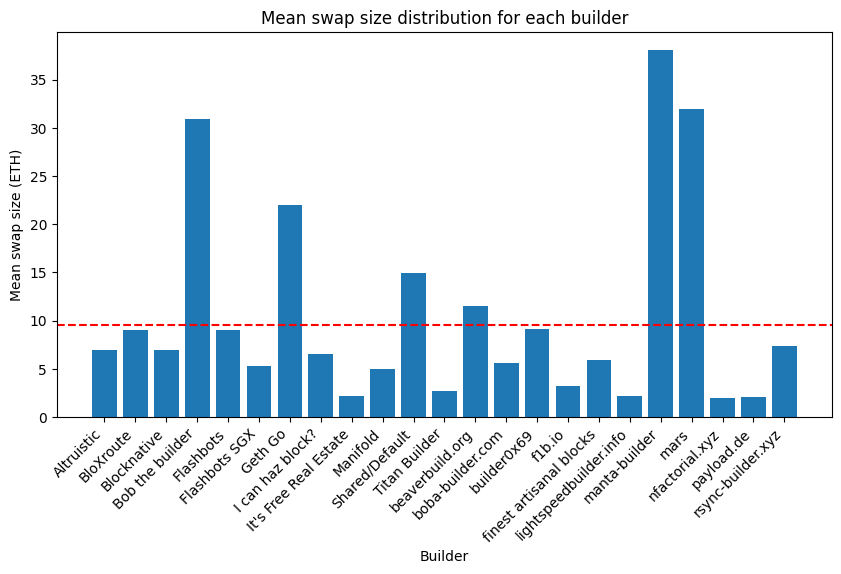

In [24]:
# Calculate the mean swap size for each builder
builder_mean_swap_size = mev_boost_builders.groupby("builder").amount.mean()

# Plot it as a histogram
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(builder_mean_swap_size.index, builder_mean_swap_size)

# Add a line for the overall mean swap size
ax.axhline(mev_boost_builders.amount.mean(), color="red", linestyle="--")

# Rotate the x-axis labels and align them to the right
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.set_title("Mean swap size distribution for each builder")
ax.set_xlabel("Builder")
ax.set_ylabel("Mean swap size (ETH)")

##### Plot median for all builders


Text(0, 0.5, 'Mean swap size (ETH)')

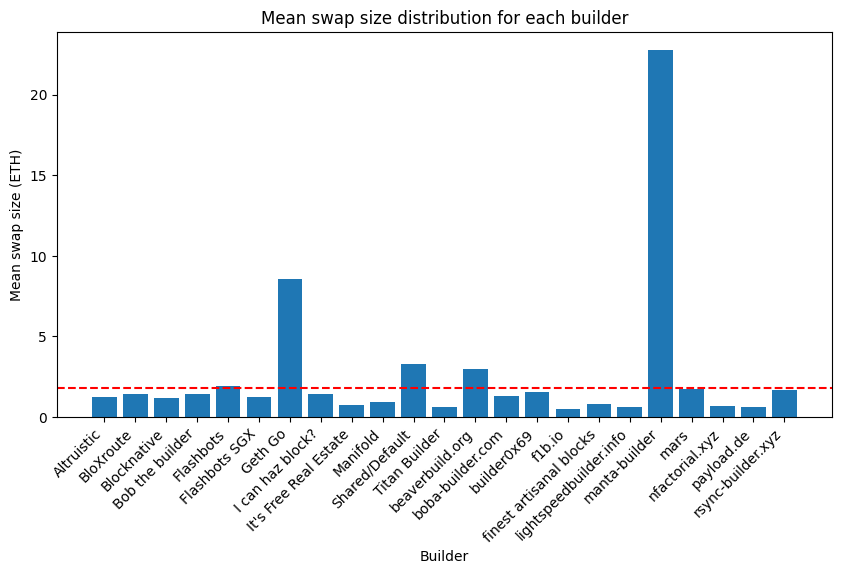

In [27]:
# Calculate the mean swap size for each builder
builder_mean_swap_size = mev_boost_builders.groupby("builder").amount.median()

# Plot it as a histogram
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(builder_mean_swap_size.index, builder_mean_swap_size)

# Add a line for the overall mean swap size
ax.axhline(mev_boost_builders.amount.median(), color="red", linestyle="--")

# Rotate the x-axis labels and align them to the right
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.set_title("Mean swap size distribution for each builder")
ax.set_xlabel("Builder")
ax.set_ylabel("Mean swap size (ETH)")

##### Compare distributions for select builders


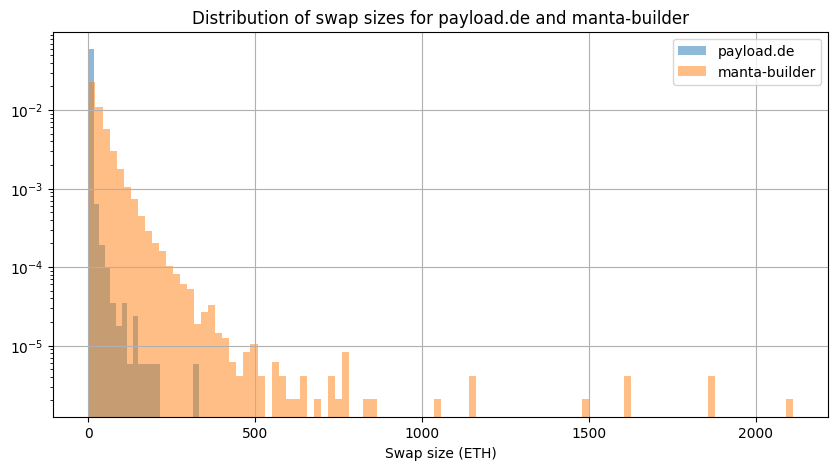

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

mev_boost_builders[mev_boost_builders.builder == "payload.de"].amount.hist(
    bins=20, log=True, ax=ax1, alpha=0.5, density=True
)
mev_boost_builders[mev_boost_builders.builder == "manta-builder"].amount.hist(
    bins=100, log=True, ax=ax1, alpha=0.5, density=True
)

ax1.set_title("Distribution of swap sizes for payload.de and manta-builder")
ax1.set_xlabel("Swap size (ETH)")

ax1.legend(["payload.de", "manta-builder"])

Text(0, 0.5, 'CDF')

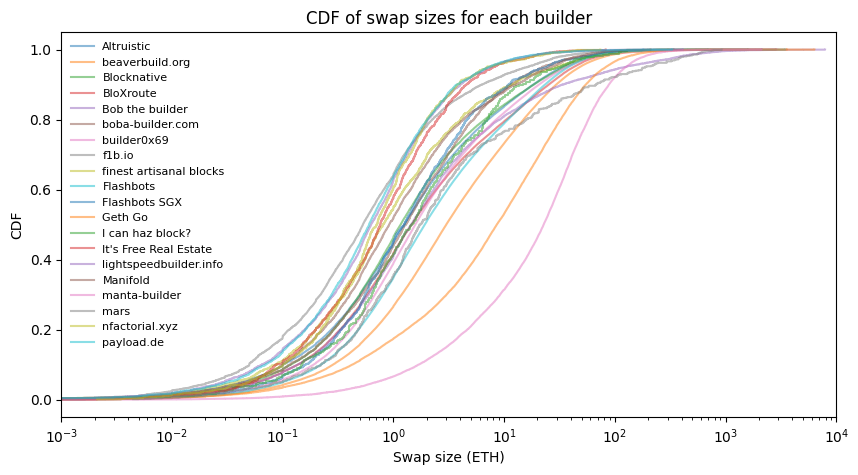

In [76]:
builders = sorted(mev_boost_builders.builder.unique(), key=lambda x: x.lower())[:20]

plt.figure(figsize=(10, 5))

for builder in builders:
    payload = (
        mev_boost_builders[mev_boost_builders.builder == builder].groupby("amount").count().sort_index().block_number
    )

    # Get PDF and get CDF
    payload /= payload.sum()
    payload = payload.cumsum()

    plt.step(payload.index, payload, where="post", label=builder, alpha=0.5)
    plt.xscale("log")

plt.legend(frameon=False, fontsize=8)
plt.xlim(1e-3, 1e4)

plt.title("CDF of swap sizes for each builder")
plt.xlabel("Swap size (ETH)")
plt.ylabel("CDF")

Text(0, 0.5, 'Mean swap size (ETH)')

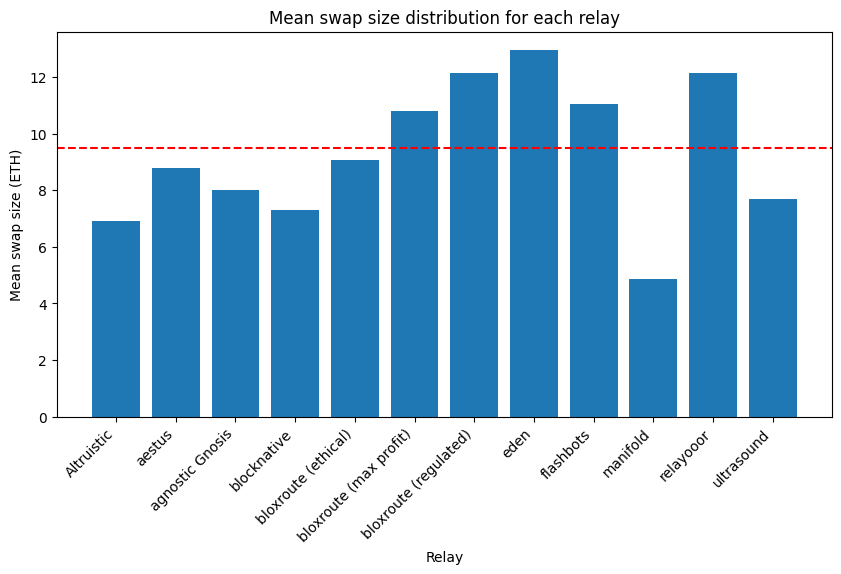

In [25]:
# Calculate the mean swap size for each relay
relay_mean_swap_size = block_mean_swap_size.groupby("relay").amount.mean()

# Plot it as a histogram
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(relay_mean_swap_size.index, relay_mean_swap_size)

ax.axhline(block_mean_swap_size.amount.mean(), color="red", linestyle="--")

# Rotate the x-axis labels and align them to the right
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.set_title("Mean swap size distribution for each relay")
ax.set_xlabel("Relay")
ax.set_ylabel("Mean swap size (ETH)")

Text(0, 0.5, 'CDF')

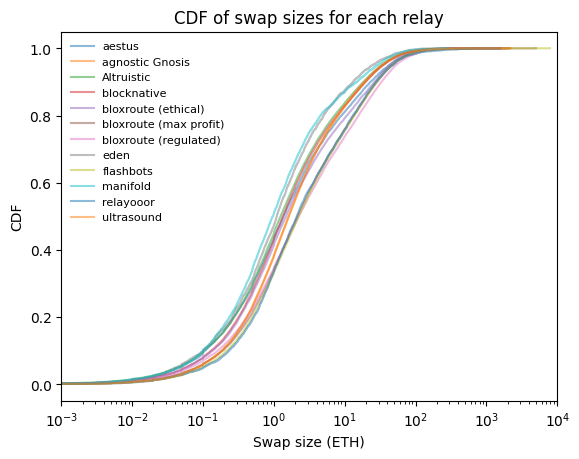

In [75]:
relays = sorted(mev_boost_builders.relay.unique(), key=lambda x: x.lower())[:20]

for builder in relays:
    payload = (
        mev_boost_builders[mev_boost_builders.relay == builder].groupby("amount").count().sort_index().block_number
    )

    # Get PDF and get CDF
    payload /= payload.sum()
    payload = payload.cumsum()

    plt.step(payload.index, payload, where="post", label=builder, alpha=0.5)
    plt.xscale("log")

plt.legend(frameon=False, fontsize=8)
plt.xlim(1e-3, 1e4)

plt.title("CDF of swap sizes for each relay")
plt.xlabel("Swap size (ETH)")
plt.ylabel("CDF")


#### Visualize results for relays
